<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [595]:
import numpy as np
from ddeint import ddeint
import matplotlib.pyplot as plt
import signalz
import utils
import sys
sys.path.append("Distribution_Regression_Streams/")
from importlib import reload
import GP_models as GP_models
from GP_models import GP_classic as GP_naive
from GP_models import GP_sig_precomputed as GP_sig
import experiments
from experiments import * 
import signature_features
from signature_features import *
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import fbm
from addtime import AddTime, LeadLag

**type of time series**

\begin{align*}
\frac{dy(t)}{dt}=-by(t)+\alpha\frac{y(t-T)}{1+y(t-T)^{10}}&& \alpha=0.2,~b=0.1, ~T=17
\end{align*}

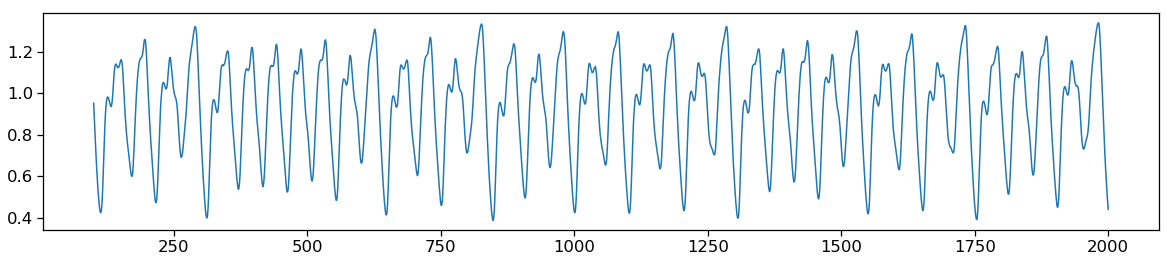

In [1828]:
def model(Y, t):
    T = 17
    alpha = 0.2
    b = 0.1
    return -b*Y(t)+alpha*Y(t - T)/(1.+Y(t-T)**10)


def values_before_zero(t):
    return 0.1


T = 2000
N_train = 150

tt = np.linspace(0,T,T)
yy = ddeint(model, values_before_zero, tt)

fig, ax =plt.subplots(1, figsize=(20, 4))
yy = [0.1]+[e[0] for e in yy[1:]]
yy = yy + 0.001*np.random.randn(len(yy))
yy = np.array(yy[100:])
tt = tt[100:]
ax.plot(tt, yy)
tau = 20
#ax.plot(tt[tau:(N_train+tau)], yy[tau:(N_train+tau)],color='red',label='train')
plt.show()
plt.show()


# fig, ax =plt.subplots(1, figsize=(10, 4))
# T = 2000
# tt = np.linspace(0,T,T)
# a = fbm.FBM(n=T,hurst=0.4,length=1)
# yy = a.fbm()[1:]
# ax.plot(tt, yy)
# tau = 500
# N_train = 300
# plt.show()
# plt.show()

**Create the dataset**

input: $(y_i,\ldots,y_{i+\tau})$ output: $y_{i+\tau+1}$


In [1829]:
reload(utils)
N_test = 300
#random_start = np.random.choice(np.arange(1250),N_train,replace=False)
random_start = np.arange(0,N_train)
start_extrapol = np.arange(N_train,N_train+N_test)

all_start = np.concatenate((random_start,start_extrapol))


data = [yy[k:(k+tau)][None,:,None] for k in all_start]
data = np.array(data)
X_aug = utils.add_dimension(data,add_time=True,lead_lag=None)
label = np.array([yy[k+tau] for k in all_start])[:,None]
train_indices = np.arange(N_train)
test_indices = np.arange(N_train,len(data))


**Train**

Although we show the test error on the rest of the time series, this is not how we intend to test. We will forecast 1-step ahead iteratively

shape of the final features (N_bags, D): (450, 30)
(450, 450)


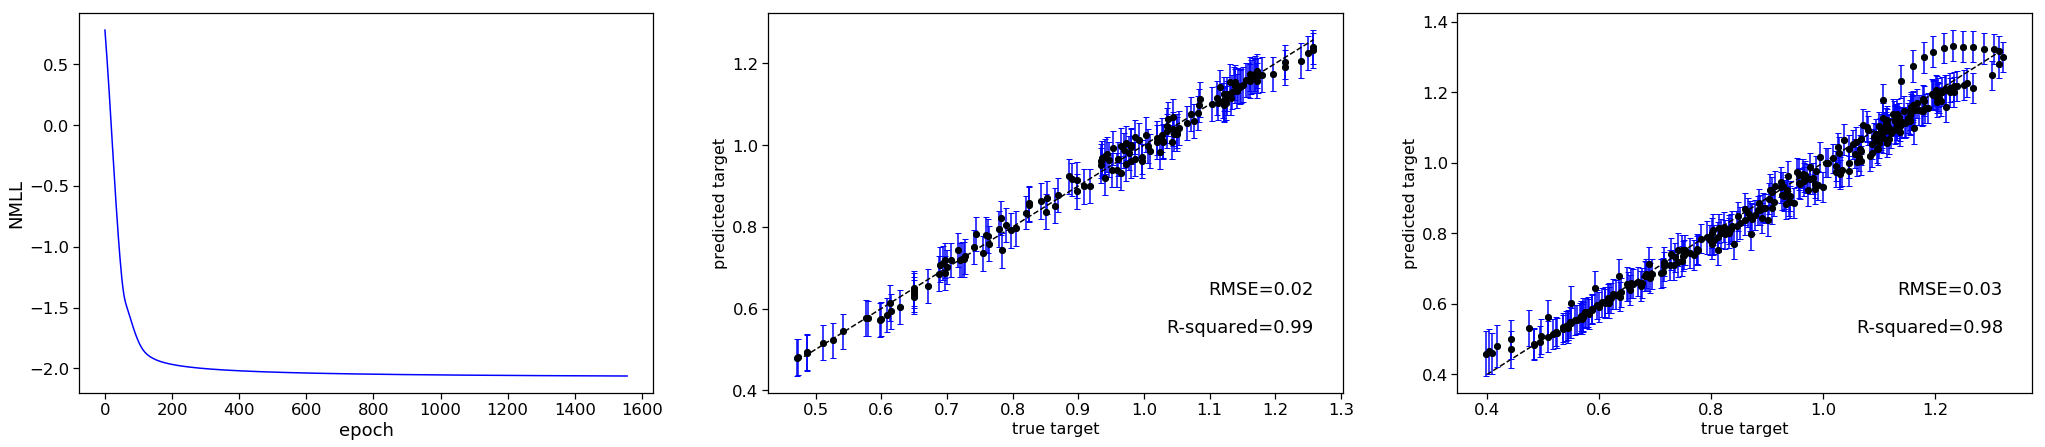

In [1832]:
reload(experiments)
reload(signature_features)
reload(GP_sig)
reload(GP_sig_ARD)

sig_level = 3

# Compute the expected signature
expected_sig = signature_features.scaled_expected_sig([e.copy() for e in X_aug],sig_level)
#expected_sig = signature_features.scaled_expected_sig([e.copy() for e in X_aug], sig_level, M=10,
 #                                                                     a=1, ilya_rescale=True, return_norms=False)
# Standard scale the features
print('shape of the final features (N_bags, D):', expected_sig.shape)

# Precompute the Gram matrix, as we do not optimize any parameter
K_precomputed = experiments.precompute_K(expected_sig)
print(K_precomputed.shape)
# Train and Predict
a,b,c,d,model,predictions = experiments.experiment_precomputed(K_precomputed,label,train_indices,test_indices,param_init=[0,0,0],RBF=False,plot=True)

In [1024]:
# fig, ax =plt.subplots(1, figsize=(15, 6))
# ax.plot(tt, yy)
# ax.plot(tt[tau:(N_train+tau)],predictions['mu_train'])
# ax.plot(tt[N_train+tau:],predictions['mu_test'])
# ax.fill_between(tt[tau:(N_train+tau)], predictions['mu_train'][:,0]-predictions['stdv_train'],predictions['mu_train'][:,0]+predictions['stdv_train'],color='orange',alpha=0.2)
# ax.fill_between(tt[(N_train+tau):], predictions['mu_test'][:,0]-predictions['stdv_test'],predictions['mu_test'][:,0]+predictions['stdv_test'],color='green',alpha=0.2)
# print(tt[N_train+tau:][0]-tt[tau:(N_train+tau)][-1])
# plt.show()

In [1329]:
print(expected_sig.shape)

(450, 30)


In [1833]:
stdv_sig = []
stream_predict = [e for e in data[N_train][0,:,0]]

for i in tqdm(range(0,N_test)):
    chunk = np.array(stream_predict)[i:(i+tau)][None,:,None]
    x_aug_test = utils.add_dimension([chunk],add_time=True,lead_lag=None)
    sig_test = signature_features.scaled_expected_sig(x_aug_test,sig_level)
    K_aug = experiments.augment_K_precomputed(K_precomputed[:N_train,:N_train],expected_sig[:N_train],sig_test[0])
    
    
#     model.K_full = model.get_K_RBF_Sig(torch.tensor(K_aug, dtype=torch.float64))
#     model.indices_1 = train_indices
#     model.indices_2 = np.array([train_indices[-1]+1])
#     mu_test, stdv_test = model.dummy_predict(None, None, RBF=True)
    
    K_s = GP_sig.get_K(K_aug, train_indices, np.array([train_indices[-1]+1]))
    K_ss = GP_sig.get_K(K_aug, np.array([train_indices[-1]+1]))  
    mu_test, stdv_test = model.dummy_predict(K_s, K_ss, RBF=False)
    stdv_sig.append(stdv_test[0])
    stream_predict.append(mu_test[0][0])

N = 500
stream_predict_unc = np.zeros((N,len(test_indices)+tau))
stream_predict_unc[:,:tau]=np.repeat(data[N_train][0,:,0][:,None],N,axis=1).T
mean = []
stdv = []

for i in tqdm(range(0,N_test)):
    chunk = stream_predict_unc[:,i:(i+tau)][:,:,None]
    x_aug_test = utils.add_dimension([chunk],add_time=True,lead_lag=None)
    sig_test = signature_features.scaled_expected_sig(x_aug_test,sig_level)
    #print(sig_test[0].shape)
    K_aug = experiments.augment_K_precomputed(K_precomputed[:N_train,:N_train],expected_sig[:N_train],sig_test[0])
    
#     model.K_full = model.get_K_RBF_Sig(torch.tensor(K_aug, dtype=torch.float64))
#     model.indices_1 = train_indices
#     model.indices_2 = np.array([train_indices[-1]+1])
#     mu_test, stdv_test = model.dummy_predict(None, None, RBF=True)
 
    K_s = GP_sig.get_K(K_aug, train_indices, np.array([train_indices[-1]+1]))
    K_ss = GP_sig.get_K(K_aug, np.array([train_indices[-1]+1]))  
    mu_test, stdv_test = model.dummy_predict(K_s, K_ss, RBF=False)
    stdv.append(stdv_test[0])
    sample = mu_test[0][0] + 0.5*stdv_test[0]*np.random.randn(N)
    stream_predict_unc[:,i+tau]=sample
    #stream_predict_unc[:,i+tau-1]=np.mean(stream_predict_unc[:,i+tau-1])
    mean.append(mu_test[0][0])

/Users/maudlemercier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/Users/maudlemercier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


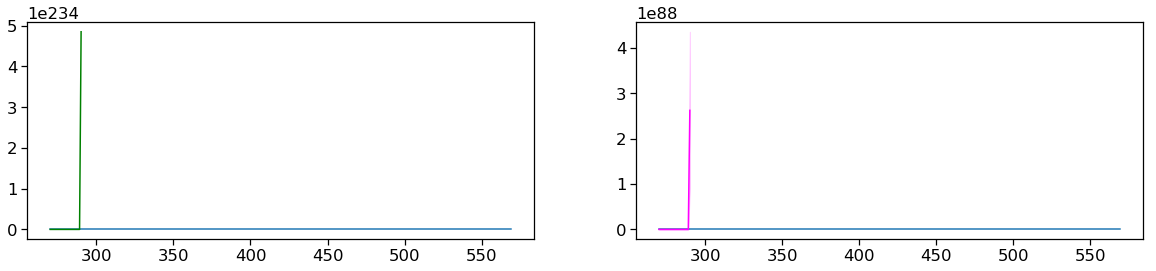

In [1834]:
#N_test = 50
fig, ax =plt.subplots(1,2, figsize=(20, 4))
ax[0].plot(tt[N_train+tau:N_train+N_test+tau],yy[N_train+tau:N_train+tau+N_test])
ax[0].plot(tt[N_train+tau:N_train+N_test+tau],stream_predict[tau:tau+N_test],color='green',label='1-step iterative prediction')
ax[0].fill_between(tt[N_train+tau:N_train+N_test+tau], stream_predict[tau:tau+N_test]-np.array(stdv_sig[:N_test]),stream_predict[tau:tau+N_test]+np.array(stdv_sig[:N_test]),color='green',alpha=0.2)


ax[1].plot(tt[N_train+tau:N_train+N_test+tau], yy[N_train+tau:N_train+tau+N_test])
ax[1].plot(tt[(N_train+tau):(N_train+N_test+tau)],mean[:(N_test)],color='magenta',label='1-step iterative prediction')
ax[1].fill_between(tt[N_train+tau:N_train+N_test+tau], mean[:N_test]-np.array(stdv[:N_test]),mean[:N_test]+np.array(stdv[:N_test]),color='magenta',alpha=0.2)

plt.show()

In [1825]:
np.mean((stream_predict[tau:tau+N_test]-yy[1250+tau:1250+tau+N_test])**2)

/Users/maudlemercier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in square
  """Entry point for launching an IPython kernel.


nan

In [1826]:
np.mean((mean[:(N_test)]-yy[1250+tau:1250+tau+N_test])**2)

nan